Используя библиотеку Natasha извлечь все названия организаций из текстов новостей. Построить граф социальной сети для организаций, упоминавшихся в новостях, считая, что две организации, встретившиеся в одной заметке связаны между собой. Рассчитать меру посредничества для вершин графа, выделить 10 вершин с самой большой мерой посредничества.


In [1]:
# скачиваем новости. я буду качать бьютифул супом, беру код из своей домашки
import requests
import tqdm
from pprint import pprint
from bs4 import BeautifulSoup
import re
from fake_useragent import UserAgent
import time
from datetime import datetime
import random
from tqdm.auto import tqdm
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

session = requests.session()
ua = UserAgent()

In [23]:
import requests
from bs4 import BeautifulSoup

url = 'https://informpskov.ru/news/450412.html'
response = requests.get(url)
soup = BeautifulSoup(response.content, 'html.parser')

# Извлечение данных
# Найти элемент <time> и извлечь дату
date_element = soup.select_one('article.article-view time')
if date_element:
    date = date_element.get_text(strip=True)[:-25]
else:
    date = "без даты"
source = "ПАИ"
author = "Автор не указан"
# Проверка наличия элемента <meta property='og:title'> и извлечение его содержимого
try:
    title = soup.find('meta', property='og:title')['content']
except (KeyError, TypeError):
    title = "Нет названия"
# Найти элемент <article class="article-view"> и извлечь текст из тега <p>
article_element = soup.find('article', class_='article-view')
if article_element:
    text = article_element.find('p').get_text(strip=True)
else:
    text = "Текст не найден"

# Сохранение в файл
with open('articles.txt', 'a', encoding='utf-8') as file:
    file.write(f"{'='*5}\n{url}\n{source}\n{date}\n{author}\n{title}\n{text}\n")


In [26]:
# обходим 20000 циклом. тут меньше в тетрадке, потому что связь с сервером 2 раза разрывалась. Но это неважно, в файле 
# их 20000
import requests
from tqdm import tqdm
from bs4 import BeautifulSoup
for i in tqdm(range(447540, 450411)):  
    url = f'https://informpskov.ru/news/{i}.html'
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')

    # извлекаем все по очереди
    # извлекаем дату
    date_element = soup.select_one('article.article-view time')
    if date_element:
        # там куча пробелов после даты
        date = date_element.get_text(strip=True)[:-25]
    else:
        date = "Без даты"
    # сурс всегда 1    
    source = "ПАИ"
    # автора у меня на сайте нет, к сожалению
    author = "Автор не указан"
    # проверка наличия 'og:title' и извлечение его содержимого
    try:
        title = soup.find('meta', property='og:title')['content']
    except (KeyError, TypeError):
        title = "Нет названия"
    # ищем элемент <article class="article-view"> и извлекаем текст из тега <p>
    article_element = soup.find('article', class_='article-view')
    if article_element:
        text = article_element.find('p').get_text(strip=True)
    else:
        text = "Текст не найден"

# сохраняем в файл
    with open('articles.txt', 'a', encoding='utf-8') as file:
        file.write(f"{'='*5}\n{url}\n{source}\n{date}\n{author}\n{title}\n{text}\n")


100%|██████████████████████████████████████████████████████████████████████████████| 2871/2871 [06:18<00:00,  7.59it/s]


Используя библиотеку Natasha извлечь все названия организаций из текстов новостей. Построить граф социальной сети для организаций, упоминавшихся в новостях, считая, что две организации, встретившиеся в одной заметке связаны между собой. Рассчитать меру посредничества для вершин графа, выделить 10 вершин с самой большой мерой посредничества.

использовать NetworkX при построении и визуализации графа			

In [4]:
pip install networkx

Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063


100%|██████████████████████████████████████████████████████████████████████████████| 5000/5000 [51:05<00:00,  1.63it/s]


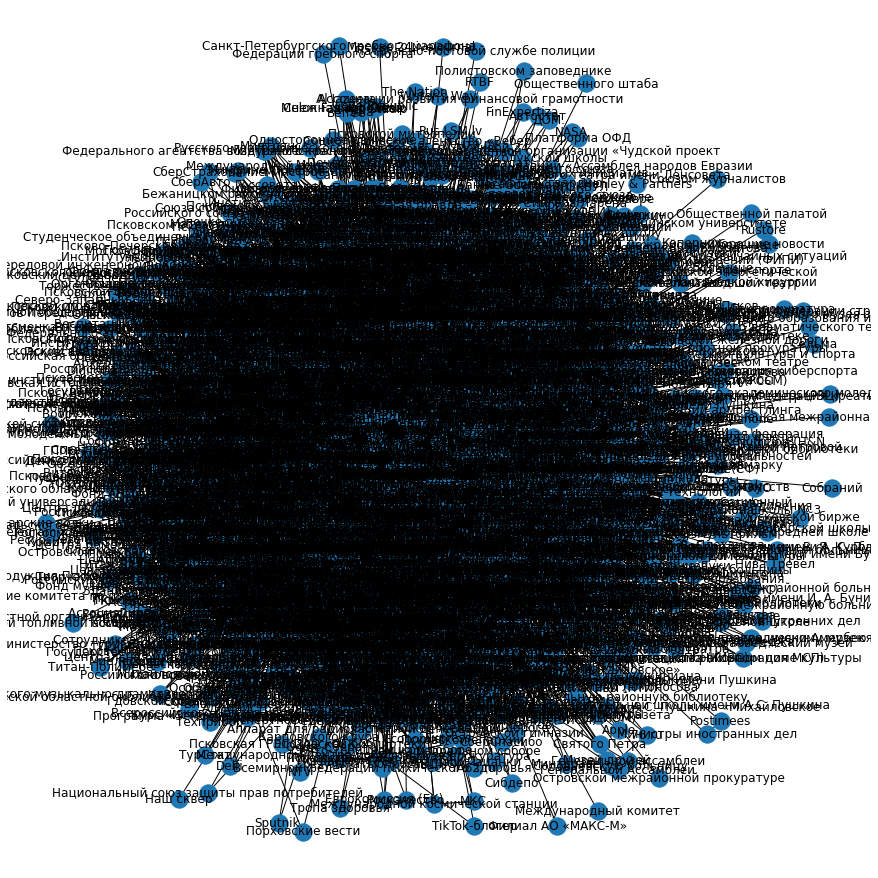

Top 10 nodes by betweenness centrality:
ПАИ: 0.5195311857675438
Псков: 0.19538504859155562
В: 0.14613443505109647
Псковской области: 0.052322554806468934
Б: 0.03397319728950869
Псковского: 0.010249105971801923
Псковский: 0.0030254463958545997
Псковском: 0.0022465851180130973
ВКонтакте: 0.0020635011541568437
ГУ: 0.0015940866006937966


In [1]:
import re
from natasha import Doc, Segmenter, NewsEmbedding, NewsMorphTagger, NewsSyntaxParser, NewsNERTagger
import networkx as nx
import matplotlib.pyplot as plt
from tqdm import tqdm


with open('articles.txt', 'r', encoding='utf-8') as file:
    data = file.read()

news_list = re.split(r'={5}', data)[:5000]  # делим на новости и берем 200 первых (20000 будут работать 24 часа)

# print(news_list)

# извлекаем названия организаций из текстов первых 100 новостей
organisations = set()
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

for news in tqdm(news_list):
    doc = Doc(news)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    
    for span in doc.spans:
        if span.type == 'ORG':
            organisations.add(span.text)

# print(organisations)
# построение графа социальной сети только на основе первых 200 новостей
G = nx.Graph()
for news in tqdm(news_list):
    for org in organisations:
        if org in news:
            G.add_node(org)
    org_list = list(organisations)
    for i in range(len(org_list)):
        for j in range(i + 1, len(org_list)):
            if org_list[i] in news and org_list[j] in news:
                G.add_edge(org_list[i], org_list[j])
                # print(1)

# print(G.nodes)
# print("_________________________")
# print(G.edges)

# визуализация
plt.figure(figsize=(12, 12))
nx.draw(G, with_labels=True)
plt.show()

# меры посредничества и вывод 10 вершин с самой большой мерой посредничества
betweenness = nx.betweenness_centrality(G)
top_10_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:")
for node, centrality in top_10_betweenness:
    print(f"{node}: {centrality}")


Сложно понять, что тут происходит. Давайте добавим порог, чтобы было удобнее изучать граф

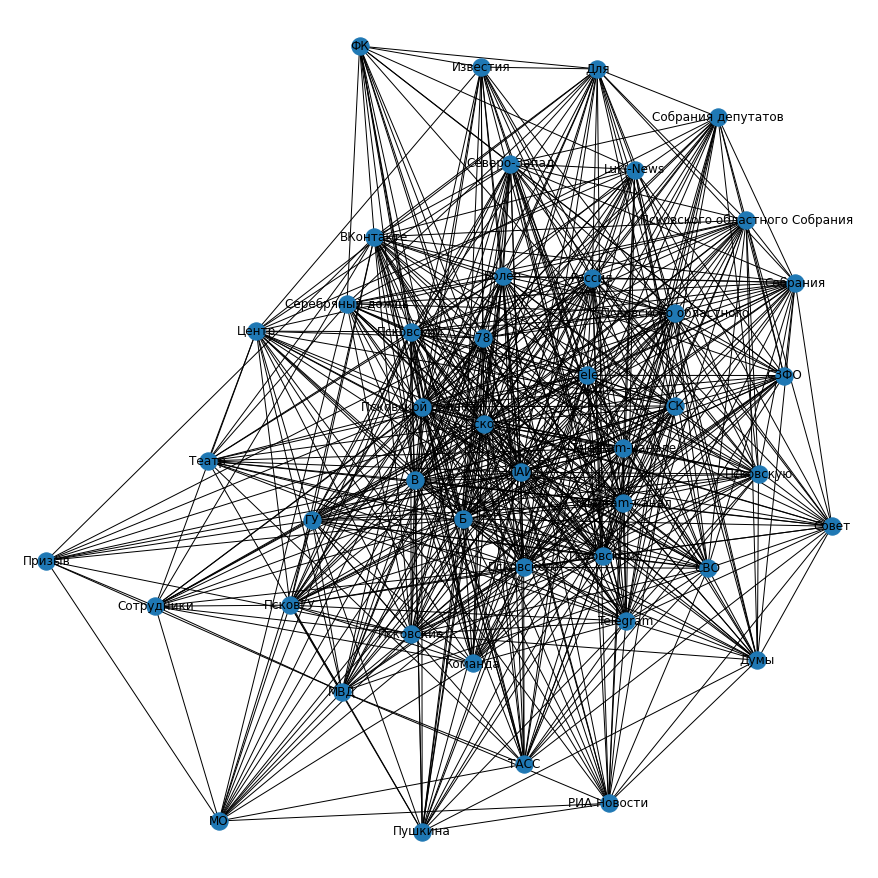

Top 10 nodes by betweenness centrality:
ПАИ: 0.5195311857675438
Псков: 0.19538504859155562
В: 0.14613443505109647
Псковской области: 0.052322554806468934
Б: 0.03397319728950869
Псковского: 0.010249105971801923
Псковский: 0.0030254463958545997
Псковском: 0.0022465851180130973
ВКонтакте: 0.0020635011541568437
ГУ: 0.0015940866006937966


In [4]:
betweenness = nx.betweenness_centrality(G)

# убираем вершины с betweenness_centrality меньше 0.0001
filtered_nodes = [node for node in G.nodes() if betweenness[node] >= 0.0001]

# создаем субграф
H = G.subgraph(filtered_nodes)


plt.figure(figsize=(12, 12))
nx.draw(H, with_labels=True)
plt.show()

top_10_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by betweenness centrality:")
for node, centrality in top_10_betweenness:
    print(f"{node}: {centrality}")

ну с ПАИ все понятно, это новостной ресурс, с которого скачаны все эти новости

In [21]:
# пришлось даунгрейднуть декоратор
pip install decorator==5.0.9

  Attempting uninstall: decorator
    Found existing installation: decorator 5.0.6
    Uninstalling decorator-5.0.6:
      Successfully uninstalled decorator-5.0.6
Note: you may need to restart the kernel to use updated packages.


DEPRECATION: pyodbc 4.0.0-unsupported has a non-standard version number. pip 24.1 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of pyodbc or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spyder 4.2.5 requires pyqt5<5.13, which is not installed.
spyder 4.2.5 requires pyqtwebengine<5.13, which is not installed.
torchvision 0.17.2 requires torch==2.2.2, but you have torch 2.2.1 which is incompatible.


Гипотеза: Псков известен своей промышленностью и туризмом. В топ-100 по центральности и в топ-100 по частотности будет много организаций, связанных с промышленностью и с туризмом. 

In [2]:
# топ-100 по центральности
betweenness = nx.betweenness_centrality(G)
top_100_betweenness = sorted(betweenness.items(), key=lambda x: x[1], reverse=True)[:100]
print("Top 10 nodes by betweenness centrality:")
for node, centrality in top_100_betweenness:
    print(f"{node}: {centrality}")

Top 10 nodes by betweenness centrality:
ПАИ: 0.5195311857675438
Псков: 0.19538504859155562
В: 0.14613443505109647
Псковской области: 0.052322554806468934
Б: 0.03397319728950869
Псковского: 0.010249105971801923
Псковский: 0.0030254463958545997
Псковском: 0.0022465851180130973
ВКонтакте: 0.0020635011541568437
ГУ: 0.0015940866006937966
Известия: 0.0015542860748160659
Центр: 0.001534279586026752
Tele: 0.0014601514734325263
Telegram: 0.0014004921004101768
Telegram-канал: 0.0013311746848885823
78: 0.001225037018550907
ПсковГУ: 0.001104405477132633
Telegram-канале: 0.001011286715682613
ТАСС: 0.0009548240072899612
Россия: 0.0009518643104457753
Более: 0.000932217101056261
РИА Новости: 0.0009280413023863143
Псковские: 0.0009062675036911573
Псковского областного: 0.0007760853780052578
Северо-Запад: 0.0007077295781391255
Серебряный дождь: 0.0004949914070745591
СВО: 0.0004753601831187453
Собрания: 0.000469894980516703
Пушкина: 0.0004625576759692788
Псковскую: 0.00045351653678350583
Совет: 0.0004379

Итого из промышленности: Машиностроитель, Ремонт.

Из туризма: Изборск, Псковского музея, Псковского музея-заповедника, Псково-Печерского монастыря.

Моя гипотеза не подтвердилась. Большинство организаций это какие-то издательства. 

In [5]:
# топ-100 по частотности
with open('articles.txt', 'r', encoding='utf-8') as file:
    data = file.read()

news_list = re.split(r'={5}', data) # делим на новости и берем 200 первых (20000 будут работать 24 часа)

# print(news_list)

# извлекаем названия организаций из текстов первых 100 новостей
organisations = []
segmenter = Segmenter()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)
syntax_parser = NewsSyntaxParser(emb)
ner_tagger = NewsNERTagger(emb)

for news in tqdm(news_list):
    doc = Doc(news)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    doc.parse_syntax(syntax_parser)
    doc.tag_ner(ner_tagger)
    
    for span in doc.spans:
        if span.type == 'ORG':
            organisations.append(span.text)
            
from collections import Counter
c = Counter(organisations)
print(c.most_common(100))

100%|████████████████████████████████████████████████████████████████████████████| 20001/20001 [05:45<00:00, 57.84it/s]

[('ПАИ', 9524), ('Серебряный дождь', 885), ('УМВД', 674), ('ВКонтакте', 672), ('Telegram-канале', 587), ('Telegram-канал', 387), ('Известия', 375), ('ПсковГУ', 362), ('МЧС', 354), ('Собрания депутатов', 323), ('Luki-News', 296), ('Псковского областного', 282), ('SuperJob', 244), ('Оглавление', 224), ('Росгвардии', 211), ('СВО', 207), ('ГУ', 204), ('Россия', 199), ('Псковском гидрометцентре', 194), ('Анамнез', 187), ('Псковской городской Думы', 186), ('МВД', 175), ('Псковского музея-заповедника', 167), ('СК', 152), ('Призыв', 151), ('АНО «Возрождение объектов культурного наследия', 131), ('Управления', 128), ('Псковского облсовпрофа', 127), ('Минкульт', 126), ('Госдумы', 121), ('РИА Новости', 120), ('Псковского областного Собрания', 117), ('Роспотребнадзора', 115), ('Бизнес-ланч', 111), ('ВДНХ', 106), ('УФСИН', 100), ('Интерфакс', 100), ('Собрания', 96), ('СУ', 95), ('Россельхознадзора', 95), ('Печорская правда', 93), ('Псковская сводка', 90), ('ТАСС', 89), ('Tele2', 89), ('Псковской об

Итого из промышленности: Россельхознадзора, Машиностроитель.

Из туризма: Псковского музея-заповедника, Псковский музей-заповедник, Псковский музей.

Моя гипотеза и тут не подтвердилась. Большинство организаций опять это какие-то издательства. 